In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import ConcatDataset
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(), # convert image to tensor
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))]) # normalize image with mean and std. Adjusts the values of the tensor so that their average is zero and their standard deviation is 1.0

In [3]:
trainset = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

# This data set is CIFAR10, which is a dataset of 50,000 32x32 color training images and 10,000 test images, labeled over 10 categories.
# The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.
# Some of the classes are: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

100%|██████████| 170498071/170498071 [00:38<00:00, 4399912.08it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


## Most activation functions have their strongest gradients around x = 0, so centering our data there can speed learning.


### You can calculate the mean and std_dev yourself by running these few lines of code:


In [4]:
#stack all train images together into a tensor of shape #(50000, 3, 32, 32) 
x = torch.stack([sample[0] for sample in ConcatDataset([trainset])])

#get the mean and std_dev of each image channel for the entire dataset
mean = torch.mean(x, dim=(0,2,3))
std = torch.std(x, dim=(0,2,3))

print(mean, std)

tensor([-1.2871e-06, -1.7074e-04,  1.1819e-04]) tensor([1.0001, 0.9999, 1.0000])


In [5]:
labels_map = { 0 : 'airplane', 1 : 'automobile', 2 : 'bird', 3 : 'cat', 4 : 'deer', 5 : 'dog', 6 : 'frog', 7 : 'horse', 8 : 'ship', 9 : 'truck'}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


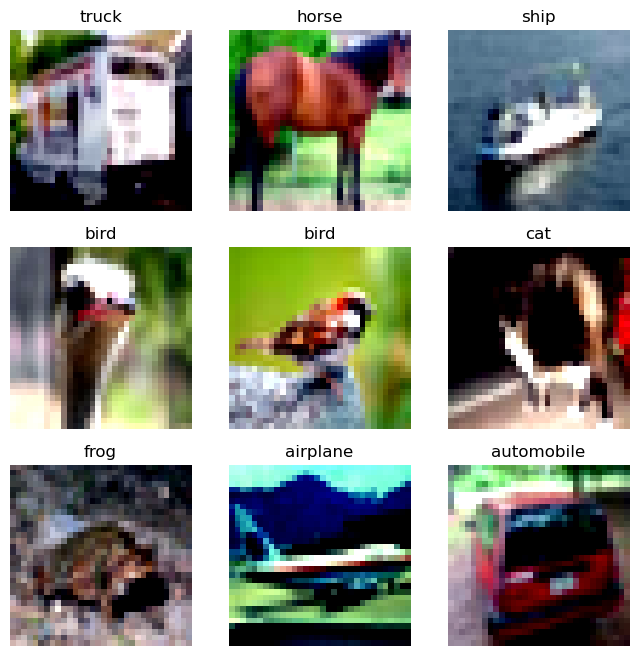

In [6]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()     # convert tensor to numpy array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(trainset), size=(1,)).item()
    img, label = trainset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    imshow(img)


In [7]:
class Net(nn.Module):
    def __init__(self): # This is the constructor method that initializes the instance of the class
        super(Net, self).__init__() # call the parent class constructor
        self.conv1 = nn.Conv2d(3, 6, 5) # 3 input image channel, 6 output channels, 5x5 square convolution kernel size
        self.pool = nn.MaxPool2d(2, 2) # This creates a max pooling layer with a kernel size of 2x2 and a stride of 2, reducing the spatial dimensions of the input by half.
        self.conv2 = nn.Conv2d(6, 16, 5) # 6 input channels, 16 output channels, 5x5 square convolution kernel size
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # This creates a linear layer that takes an input of size 16 * 5 * 5 (flattened from the previous layer's output) and has 120 output units.
        self.fc2 = nn.Linear(120, 84) # This creates another linear layer with 120 input units and 84 output units.
        self.fc3 = nn.Linear(84, 10) # This creates a final linear layer with 84 input units (from the previous layer) and 10 output units, which is the number of classes in CIFAR-10.

    def forward(self, x): # The forward method defines how the input tensor x is processed through the network. It returns the output tensor.
        x = self.pool(F.relu(self.conv1(x))) # Applies the first convolutional layer, followed by a ReLU activation function, and then a max pooling layer.
        x = self.pool(F.relu(self.conv2(x))) # Applies the second convolutional layer, followed by a ReLU activation function, and then a max pooling layer.
        x = x.view(-1, 16 * 5 * 5) # Reshapes the output from the convolutional layers into a 1D tensor to be used as input for the linear layers.
        x = F.relu(self.fc1(x)) # Applies the first linear layer followed by a ReLU activation function.
        x = F.relu(self.fc2(x)) # Applies the second linear layer followed by a ReLU activation function.
        x = self.fc3(x) # Applies the final linear layer.
        return x


net = Net()

In [8]:
criterion = nn.CrossEntropyLoss() # This criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class. It is useful when training a classification problem with C classes.
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # Stochastic Gradient Descent (SGD) is used to optimize the weights of the network. The learning rate is set to 0.001 and the momentum is set to 0.9.
# The optimizer is what drives the learning
# Besides parameters of the algorithm, like the learning rate (lr) and momentum, we also pass in net.parameters(), which is a collection of all the learning weights in the model - which is what the optimizer adjusts.

print('criterion:', criterion)
print('optimizer:', optimizer)

criterion: CrossEntropyLoss()
optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)


In [9]:
for epoch in range(25):  # loop over the dataset multiple times

    running_loss = 0.0 # initialize a variable to keep track of the loss and accumulate the loss over mini-batches.
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs) # returns the output tensor of the network (the predictions)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')


[1,  2000] loss: 2.089
[1,  4000] loss: 1.745
[1,  6000] loss: 1.607
[1,  8000] loss: 1.524
[1, 10000] loss: 1.483
[1, 12000] loss: 1.417
[2,  2000] loss: 1.369
[2,  4000] loss: 1.351
[2,  6000] loss: 1.306
[2,  8000] loss: 1.305
[2, 10000] loss: 1.285
[2, 12000] loss: 1.262
[3,  2000] loss: 1.197
[3,  4000] loss: 1.196
[3,  6000] loss: 1.201
[3,  8000] loss: 1.202
[3, 10000] loss: 1.200
[3, 12000] loss: 1.187
[4,  2000] loss: 1.077
[4,  4000] loss: 1.115
[4,  6000] loss: 1.120
[4,  8000] loss: 1.131
[4, 10000] loss: 1.109
[4, 12000] loss: 1.113
[5,  2000] loss: 1.033
[5,  4000] loss: 1.040
[5,  6000] loss: 1.065
[5,  8000] loss: 1.040
[5, 10000] loss: 1.046
[5, 12000] loss: 1.050
[6,  2000] loss: 0.969
[6,  4000] loss: 0.991
[6,  6000] loss: 0.986
[6,  8000] loss: 1.011
[6, 10000] loss: 1.022
[6, 12000] loss: 1.003
[7,  2000] loss: 0.905
[7,  4000] loss: 0.945
[7,  6000] loss: 0.949
[7,  8000] loss: 0.963
[7, 10000] loss: 0.972
[7, 12000] loss: 0.989
[8,  2000] loss: 0.890
[8,  4000] 

In [10]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))
print('Predicted:', predicted)


Accuracy of the network on the 10000 test images: 59 %
Predicted: tensor([5, 5, 1, 7])


In [11]:
# Save the model
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)